# **Integrated Gradients to explain DNN Models on Tabular Data**


This example illustrates the use of Integrated Gradients on Tabular Data. 
**Integrated Gradients** is an attribution method designed to explain the predictions of deep neural networks by assigning an importance score to each input feature. In other words, it helps answer the question: “How much did each feature contribute to this prediction?”

### Basic Idea: 
 We measure the cumulative effect of each input feature by "integrating" the gradients of the model's output  w.r.t the input along the path of some baseline (usually one that represents absence of features). 

 Definition of IG:

Let:
-	 F: $\mathbb{R}^n \rightarrow \mathbb{R}$  be the model (typically a deep neural network) that produces a prediction.
-	 $x \in \mathbb{R}^n$  be the actual input.
-	 $x^{\prime} \in \mathbb{R}^n$  be a baseline input (e.g., a vector of zeros or some neutral reference point).

The integrated gradient for the i-th input feature is defined as:

 $$
\text{IG}_i(x) = (x_i - x'_i) \times \int_{0}^{1} \frac{\partial F\big(x' + \alpha (x - x')\big)}{\partial x_i} \, d\alpha
$$

In this example, we'll use integrated gradients as provided by the Captum library for PyTorch. 

## **1. Import necessary libraries**

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from captum.attr import IntegratedGradients


torch.manual_seed(34)
np.random.seed(34)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **2. Load the Portuguese bank dataset**

- We will use the Portuguese bank dataset that we used for the Accumulated Local Effects (ALE) example. 
- To recap,these are 16 direct marketing (phone calls related) features from 45,211 clients and task is to  classify if client will subscribe a term deposit or not. 
- Dataset URL:  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip


In [2]:
df = pd.read_csv("../datasets/bank_marketing/bank-full.csv", delimiter=";")
display(df.head())
print(df.shape)
print(
    df["y"].value_counts()
)  # let's see if there is data imbalance in the target variable

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


(45211, 17)
y
no     39922
yes     5289
Name: count, dtype: int64


## **3. Preprocess data and create Pytorch tensors**

We have categorical features and numerical features. we transform categorical features to on-hot encoding and numerical features are scaled accordingly. 



In [3]:
# Automatically determine categorical and numerical features
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


# Remove the target variable (if included in the dataset)
target_variable = "y"
if target_variable in categorical_features:
    categorical_features.remove(target_variable)
if target_variable in numerical_features:
    numerical_features.remove(target_variable)

# Define the ColumnTransformer
one_hot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler, numerical_features),  # Scale numerical features
        (
            "cat",
            one_hot_encoder,
            categorical_features,
        ),  # One-hot encode categorical features
    ]
)

# Separate features and target
X = df.drop(target_variable, axis=1)
y = df[target_variable]

# Convert true labels to binary format
y = (y == "yes").astype(int)

# Apply the transformation to features
processed_X = preprocessor.fit_transform(X)

# Extract the fitted OneHotEncoder
one_hot_encoder = preprocessor.named_transformers_["cat"]

# Get one-hot encoded column names
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(categorical_features)

# Combine with scaled numerical column names
final_column_names = numerical_features + list(one_hot_encoded_columns)
print(final_column_names)

# Create a DataFrame with the transformed data
processed_X_df = pd.DataFrame(processed_X, columns=final_column_names)

# Display the DataFrame
display(processed_X_df.head())


X_train, X_test, y_train, y_test = train_test_split(
    processed_X_df, y, test_size=0.2, stratify=y, random_state=42
)

X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).view(-1, 1).float()

X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).view(-1, 1).float()

Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
Numerical Features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_un

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## **4. Define the Model**

For this example, we will use a 4-layered MLP network with dropout. This is pretty straightforward

In [4]:
# create a four layer neural network with ReLU activation functions

batch_size = 64
num_epochs = 120
learning_rate = 0.001
size_hidden1 = 80
size_hidden2 = 30
size_hidden3 = 10
size_output = 1


class DNNModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(51, size_hidden1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=dropout_rate)

        self.fc4 = nn.Linear(size_hidden3, size_output)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.drop2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.fc4(x)
        # x = self.sigmoid(x) # no need to apply sigmoid here, as we will use BCEWithLogitsLoss
        return x

## **5. Train the model**

Let's train the model for 120 epochs. For simplicity, we will not be doing any hyperparameter optimzation or k-fold cross validation. To save time, we have pre-trained the model and saved the weights. The function will train if no weights are present, otherwise, it will simply load the pretrained weights or checkpoint.

The dataset is highly imbalanced with 39922 examples with negative outcome and only 5289 calls with positive outcomes (subscribed to term deposits) -- a ratio of 7.55. To compensate for this imbalance we use weighted loss with a pos_weight of 7.55. To improve training, we use xavier initialization and low lr.


In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):  # Apply to Linear layers only
        init.xavier_uniform_(m.weight)  # Xavier (Glorot) initialization
        if m.bias is not None:
            init.zeros_(m.bias)  # Initialize biases to zero


def train(model, num_epochs, criterion, optimizer, train_iter, device):
    model.apply(initialize_weights)  # Apply initialization to the model
    model.to(device)  # Move model to device
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_iter, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU/CPU

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Print average loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_loss = running_loss / len(train_iter)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


def train_load_save_model(
    model_obj, model_path, num_epochs, criterion, optimizer, train_iter, device
):
    if os.path.isfile(model_path):
        # load model
        print("Loading pre-trained model from: {}".format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
        model_obj.to(device)
    else:
        # train model
        model_obj = model_obj.to(device)
        train(model_obj, num_epochs, criterion, optimizer, train_iter, device)
        print(
            "Finished training the model. Saving the model to the path: {}".format(
                model_path
            )
        )
        dir_path = "".join(model_path.split("/")[0:-1])
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        torch.save(model_obj.state_dict(), model_path)

In [6]:
model = DNNModel()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(7.55))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

SAVED_MODEL_PATH = "models/bank_model.pt"

# Create dataset for training
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

# Train model
train_load_save_model(
    model, SAVED_MODEL_PATH, num_epochs, criterion, optimizer, train_iter, device
)

Epoch [10/120], Loss: 0.5902
Epoch [20/120], Loss: 0.5558
Epoch [30/120], Loss: 0.5345
Epoch [40/120], Loss: 0.5341
Epoch [50/120], Loss: 0.5246
Epoch [60/120], Loss: 0.5190
Epoch [70/120], Loss: 0.5105
Epoch [80/120], Loss: 0.5124
Epoch [90/120], Loss: 0.4970
Epoch [100/120], Loss: 0.4972
Epoch [110/120], Loss: 0.4946
Epoch [120/120], Loss: 0.4801
Finished training the model. Saving the model to the path: models/bank_model.pt


## **6. Training Results**

Of course, with hyperparameter optimization we could possibly get better results, but the objective here is to illustrate IG as a post-hoc explainability method, not model optimization. Let's proceed with this model. 


Accuracy:  0.8499391794758376
ROC AUC: 0.9154654935470926


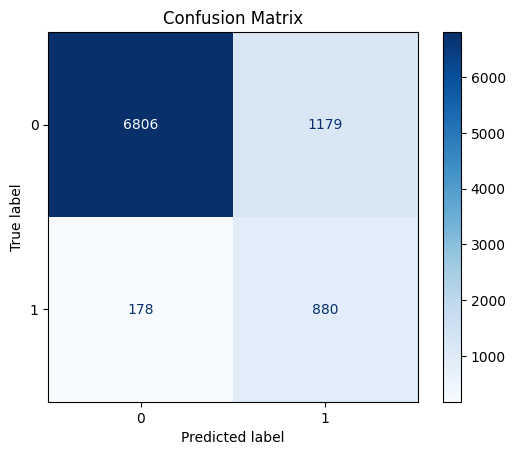

In [7]:
# Evaluate test set
model.eval()
outputs = model(X_test.to(device))
predicted = outputs > 0.5
outputs, predicted = outputs.detach().cpu().numpy(), predicted.cpu().float()

# Calculate accuracy
total = y_test.size(0)
correct = (predicted == y_test).sum().item()
accuracy = correct / total
print("Accuracy: ", accuracy)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, outputs)
print("ROC AUC:", roc_auc)
conf_mat = confusion_matrix(y_test, predicted)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

##  **7. Compute Global explanations using Integrated Gradients**

- Here, we can compute feature attribution for all datapoints in the test set and visualize individual feature contributions.
- This process is usually time consuming as for each row in the test set, the IG computation has to be repeated n_steps times.
- For sake of time, we pre-compute and save the attributions.

In [8]:
def compute_and_save_ig_attributions(
    model,
    X_test,
    final_column_names,
    ig_attr_path="models/ig_attr_test.npy",
    ig_attr_norm_sum_path="models/ig_attr_test_norm_sum.npy",
    feature_names_path="models/feature_names.txt",
):
    if (
        not os.path.exists(ig_attr_path)
        or not os.path.exists(ig_attr_norm_sum_path)
        or not os.path.exists(feature_names_path)
    ):
        # Compute IG attributions
        ig = IntegratedGradients(model)
        ig_attr_test = ig.attribute(X_test.to(device), n_steps=50)

        # Convert to numpy for saving
        ig_attr_test_np = ig_attr_test.detach().cpu().numpy()

        # Save as a .npy file for fast loading
        np.save(ig_attr_path, ig_attr_test_np)

        # Also save the summed and normalized version
        ig_attr_test_sum = ig_attr_test_np.sum(0)
        ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(
            ig_attr_test_sum, ord=1
        )
        np.save(ig_attr_norm_sum_path, ig_attr_test_norm_sum)

        # Save feature names for reference
        with open(feature_names_path, "w") as f:
            for name in final_column_names:
                f.write(f"{name}\n")
        print("IG attributions computed and saved.")
    else:
        print("IG attributions already exist. Skipping computation.")


# Call the function and only run IG computations if the precomputed attributions don't exist
compute_and_save_ig_attributions(model, X_test, final_column_names)

IG attributions computed and saved.


IG Attribution Shape: (9043, 51)
Feature Names: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


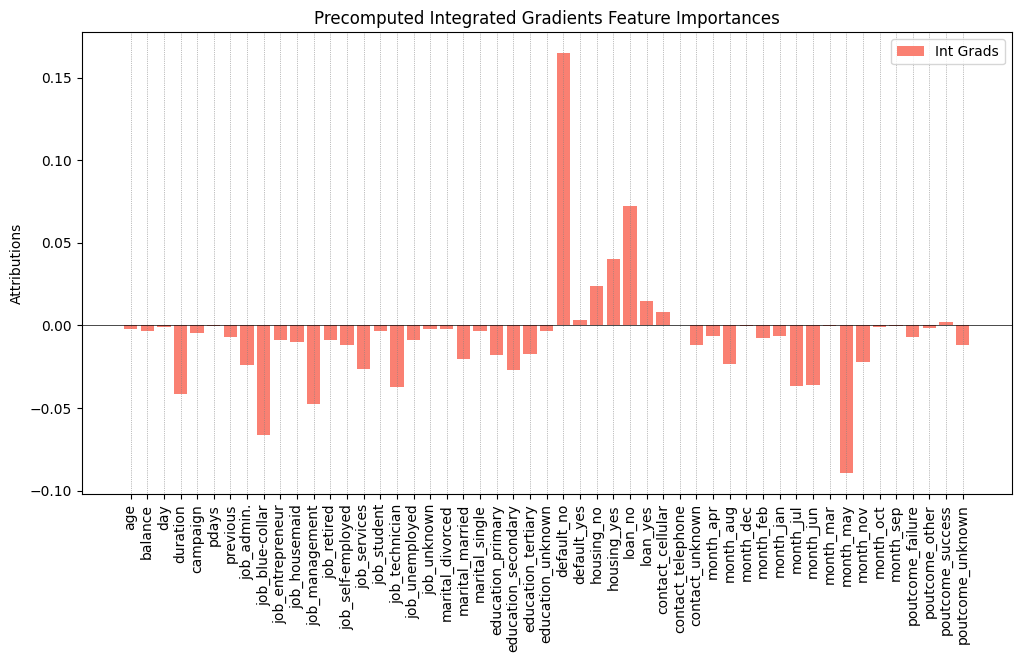

In [9]:
# Load precomputed IG attributions
ig_attr_test_np = np.load("models/ig_attr_test.npy")

# Load summed and normalized IG attributions
ig_attr_test_norm_sum = np.load("models/ig_attr_test_norm_sum.npy")

# Load feature names
with open("models/feature_names.txt", "r") as f:
    feature_names = [line.strip() for line in f]

# Verify data shape
print("IG Attribution Shape:", ig_attr_test_np.shape)
print("Feature Names:", feature_names)
# Create a bar plot for feature attributions
x_axis_data = np.arange(len(feature_names))
plt.figure(figsize=(12, 6))
plt.bar(x_axis_data, ig_attr_test_norm_sum, color="salmon", label="Int Grads")
plt.xticks(x_axis_data, feature_names, rotation=90, fontsize=10)
plt.ylabel("Attributions")
plt.title("Precomputed Integrated Gradients Feature Importances")
plt.legend()

# Draw dotted lines from xticks labels to the y-axis
for i in range(len(feature_names)):
    plt.axvline(x=i, color="gray", linestyle="dotted", linewidth=0.5)

# Draw y-axis
plt.axhline(y=0, color="black", linewidth=0.5)

plt.show()

### Global explanations

From the bar plot, it can be noted that the features `default_no`, `loan_no` are significant indicators of a positive outcome in the trained model. This means if the client has not defaulted before and if they do not have any loans, the likelihood of these clients to subscribe to a term deposit is high.

We also see that the month of May, is attributed to negative outcome. Similarly, if the client is a blue collar worker and is either in the management or technician role leads to negative outcomes. 

To dig deeper why the month of May leads to negative outcome, let's check the distribution of calls across the months in a year in the dataset.

<Axes: xlabel='month'>

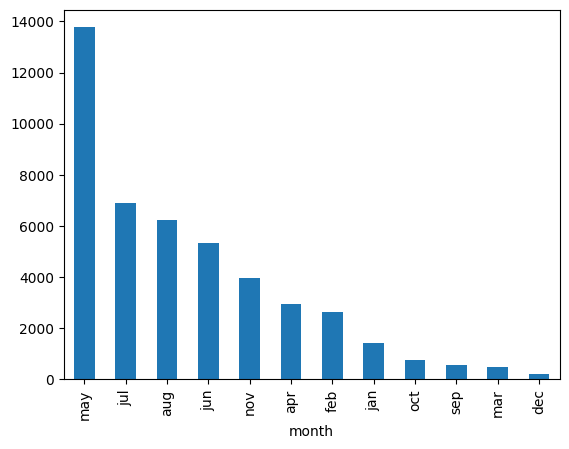

In [10]:
df["month"].value_counts().plot(
    kind="bar"
)  # let's see the distribution of the month column

Okay, here we see that the majority of the calls were made in the month of May! 	
-	Since a large number of calls happen in May, many clients might have already been contacted multiple times, leading to customer fatigue.
-	Customers may perceive these calls as too aggressive or repetitive, making them less likely to subscribe.

### Local explanations

Let's plot the IG attributions for a specific client:

Predicted Probability: 0.3309752941131592
Predicted Class: 0
True Class: 0.0


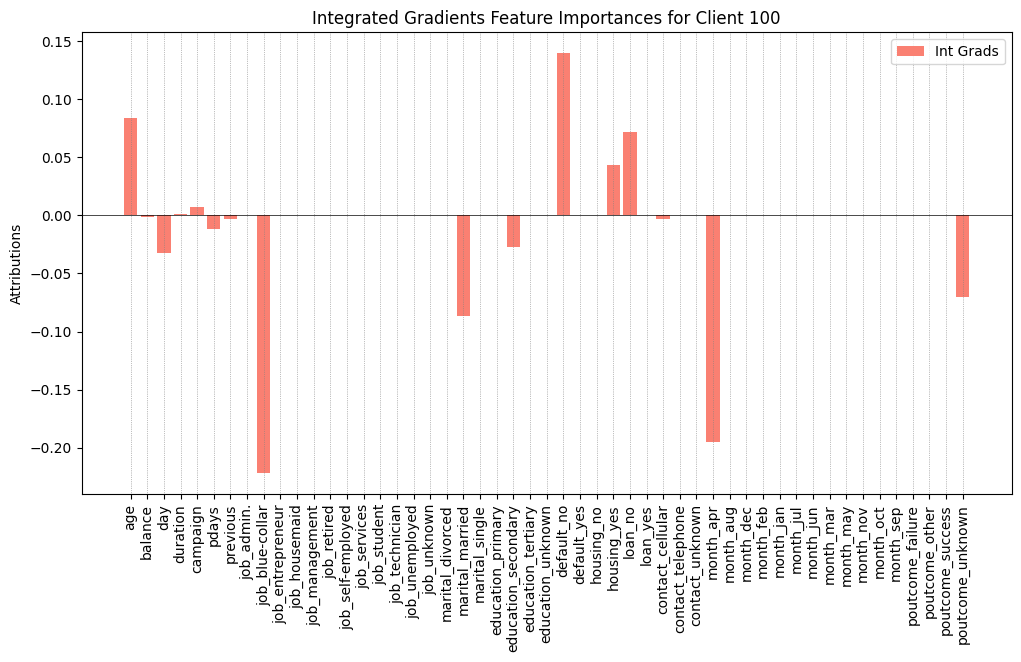

In [11]:
# plot IG attribution for client 100 in the test set. we'll load the data and the model, and then compute the IG attributions for the client
client_idx = 100
client_data = X_test[client_idx].unsqueeze(0).to(device)
client_output = model(client_data)
client_output_prob = torch.sigmoid(client_output).item()
client_output_class = 1 if client_output_prob > 0.5 else 0
print("Predicted Probability:", client_output_prob)
print("Predicted Class:", client_output_class)
print("True Class:", y_test[client_idx].item())

# plot IG attributions
ig = IntegratedGradients(model)
ig_attr_client = ig.attribute(client_data, n_steps=50)
ig_attr_client = ig_attr_client.squeeze(0).detach().cpu().numpy()
ig_attr_client_norm = ig_attr_client / np.linalg.norm(ig_attr_client, ord=1)
plt.figure(figsize=(12, 6))
plt.bar(x_axis_data, ig_attr_client_norm, color="salmon", label="Int Grads")

plt.xticks(x_axis_data, feature_names, rotation=90, fontsize=10)
plt.ylabel("Attributions")
plt.title("Integrated Gradients Feature Importances for Client 100")
plt.legend()

# Draw dotted lines from xticks labels to the y-axis
for i in range(len(feature_names)):
    plt.axvline(x=i, color="gray", linestyle="dotted", linewidth=0.5)

# Draw y-axis
plt.axhline(y=0, color="black", linewidth=0.5)

plt.show()

**job_blue_collar (Most Negative Attribution)**
-	Being in a blue-collar job significantly decreased the likelihood of subscribing.
-	Possible reasons:
	-	Blue-collar workers may have less financial flexibility to invest in term deposits.
	-	Their income levels and job stability might not align with long-term savings products.
	-	Historically, in banking datasets like UCI’s, blue-collar workers tend to have lower subscription rates.

**month_apr (Very Negative Attribution)**
- If the marketing call happened in April, the client was significantly less likely to subscribe.
- Possible reasons:
	-	April could be a time when people prioritize tax payments and avoid new financial commitments.
	-	Seasonality effects—April might not be an ideal month for term deposits compared to months like September or December.

**education_secondary (Negative Attribution)**
-	Having secondary education instead of higher education might have slightly decreased the likelihood of subscribing.
-	Possible reasons:
	-	Clients with higher education levels (college/university) may be more financially literate and more likely to invest in term deposits.
	-	Secondary-educated individuals may prefer short-term savings over fixed-term deposits.


**Conclusions**

- Consider targeting white-collar jobs more aggressively: 
	- Blue-collar workers show less interest in term deposits, so marketing strategies might need more tailored financial education.
-	April campaigns might not be effective: If April shows consistently negative attributions across multiple clients, it might not be an ideal marketing period.
-	Education matters in financial product marketing: Clients with only secondary education may need simpler messaging or better financial awareness campaigns to improve conversion rates.